# Model Comparison - Option 2
#### The objective is to compare different machine learning models and evaluate performance using confusion matrix and classification report
- For this comparison, we will handle null values by dropping all columns and rows with NaN
- We will use data for years 2011 to 2016 because data is consistent and equal data points are available for each year

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
import numpy as np
import pandas as pd
import datetime as dt
import config as cfg

from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Import Data from Postgre

In [47]:
# import data from AWS RDS Database
conn_string = "host="+cfg.PGHOST +" port="+ "5432" +" dbname="+ cfg.PGDATABASE +" user=" + cfg.PGUSER \
                  +" password="+ cfg.PGPASSWORD
    
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

df = pd.read_sql_query('select * from weather_aus_raw where year >=2011 and year <= 2016',  conn)
df.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2011-01-01,Albury,23.2,35.8,0.0,9999.0,9999.0,ENE,26.0,S,...,1009.2,9999.0,9999.0,26.8,32.8,No,No,2011,1,1
1,2011-01-02,Albury,20.1,31.1,0.6,9999.0,9999.0,W,35.0,SW,...,1009.5,9999.0,9999.0,25.1,30.2,No,No,2011,1,2
2,2011-01-03,Albury,13.6,29.4,0.0,9999.0,9999.0,WNW,35.0,SSE,...,1009.3,9999.0,9999.0,20.2,28.4,No,No,2011,1,3
3,2011-01-04,Albury,13.9,29.2,0.0,9999.0,9999.0,SSE,24.0,SE,...,1007.8,9999.0,9999.0,19.9,27.9,No,No,2011,1,4
4,2011-01-05,Albury,16.0,28.9,0.0,9999.0,9999.0,SSE,31.0,ENE,...,1004.3,9999.0,9999.0,22.0,26.8,No,No,2011,1,5


## Data Analysis

In [48]:
df.shape

(100935, 26)

In [49]:
# Check Datatypes

df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [50]:
df = df.replace('9999', np.nan)
df = df.replace(9999, np.nan)

In [51]:
print('unique location count: ', df['location'].nunique())

unique location count:  49


In [52]:
print(df['raintoday'].value_counts())
print('raintomorrow: ' , df['raintomorrow'].unique())
print('windgustdir: ' , df['windgustdir'].unique())
print('Humidity3pm: ' , df['humidity3pm'].unique())

No     76427
Yes    21979
Name: raintoday, dtype: int64
raintomorrow:  ['No' 'Yes' nan]
windgustdir:  ['ENE' 'W' 'WNW' 'SSE' 'NNE' 'NE' 'WSW' 'E' 'N' 'SW' 'NW' 'S' 'SE' 'ESE'
 'SSW' 'NNW' nan]
Humidity3pm:  [ 29.  27.  28.  38.  31.  34.  42.  40.  41.  87.  84.  59.  90.  46.
  36.  43.  37.  30.  20.  32.  25.  16.  49.  50.  99.  95.  45.  55.
  94.  57.  85.  51.  67.  54.  56.  61.  47.  58.  63.  64.  52.  66.
  53.  39.  89.  74.  48.  65.  72.  75.  79.  68.  92.  69.  70.  80.
  73.  88.  81.  76.  44.  83.  91.  71.  nan  33.  93.  35.  60.  78.
  62.  22.  21.  23.  19.  26.  18.  24.  86.  15. 100.  96.  97.  82.
  77.  17.  12.  11.  13.  98.  14.  10.   9.   7.   8.   6.   3.   5.
   1.   4.   2.   0.]


## Handle Null Values

In [53]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

df = df.reset_index(drop=True)

df.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2011-01-01,CoffsHarbour,17.8,27.1,0.0,6.0,13.0,NE,52.0,NNW,...,1013.3,2.0,1.0,25.0,26.6,No,No,2011,1,1
1,2011-01-02,CoffsHarbour,23.5,30.9,0.0,7.2,11.6,NNE,57.0,NNW,...,1009.6,2.0,3.0,27.0,27.4,No,No,2011,1,2
2,2011-01-03,CoffsHarbour,22.2,27.6,0.0,3.0,6.3,SSW,46.0,SSW,...,1009.2,7.0,6.0,25.4,26.9,No,No,2011,1,3
3,2011-01-04,CoffsHarbour,22.7,27.3,0.0,6.6,6.7,NNE,50.0,SSW,...,1008.3,6.0,7.0,25.2,26.4,No,No,2011,1,4
4,2011-01-05,CoffsHarbour,19.2,25.8,0.0,5.0,1.3,SSW,48.0,ESE,...,1004.5,7.0,7.0,23.9,25.1,No,Yes,2011,1,5


In [54]:
import plotly.express as px
px.histogram(df , x = 'location' , title ='Location vs. Rainy Days' ,color ='raintoday')

In [55]:
import plotly.express as px
px.histogram(df , x = 'location' , title ='Location vs. Expected Rainy Days' ,color ='raintomorrow')

In [56]:
print('unique location count: ', df['location'].nunique())

unique location count:  25


## Update "RainTomorrow" and "RainToday" Columns to Binary Values

In [57]:
df['raintomorrow'].value_counts()

No     28826
Yes     8103
Name: raintomorrow, dtype: int64

In [58]:
df['raintoday'].value_counts()

No     28778
Yes     8151
Name: raintoday, dtype: int64

In [59]:
df['raintomorrow'] = df.raintomorrow.eq('Yes').mul(1)
df['raintomorrow'] = df['raintomorrow'].astype(int)
df['raintomorrow'].value_counts()

0    28826
1     8103
Name: raintomorrow, dtype: int64

In [60]:
df['raintoday'] = df.raintoday.eq('Yes').mul(1)
df['raintoday'] = df['raintoday'].astype(int)
df['raintoday'].value_counts()

0    28778
1     8151
Name: raintoday, dtype: int64

In [61]:
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday          int32
raintomorrow       int32
year               int64
month              int64
day                int64
dtype: object

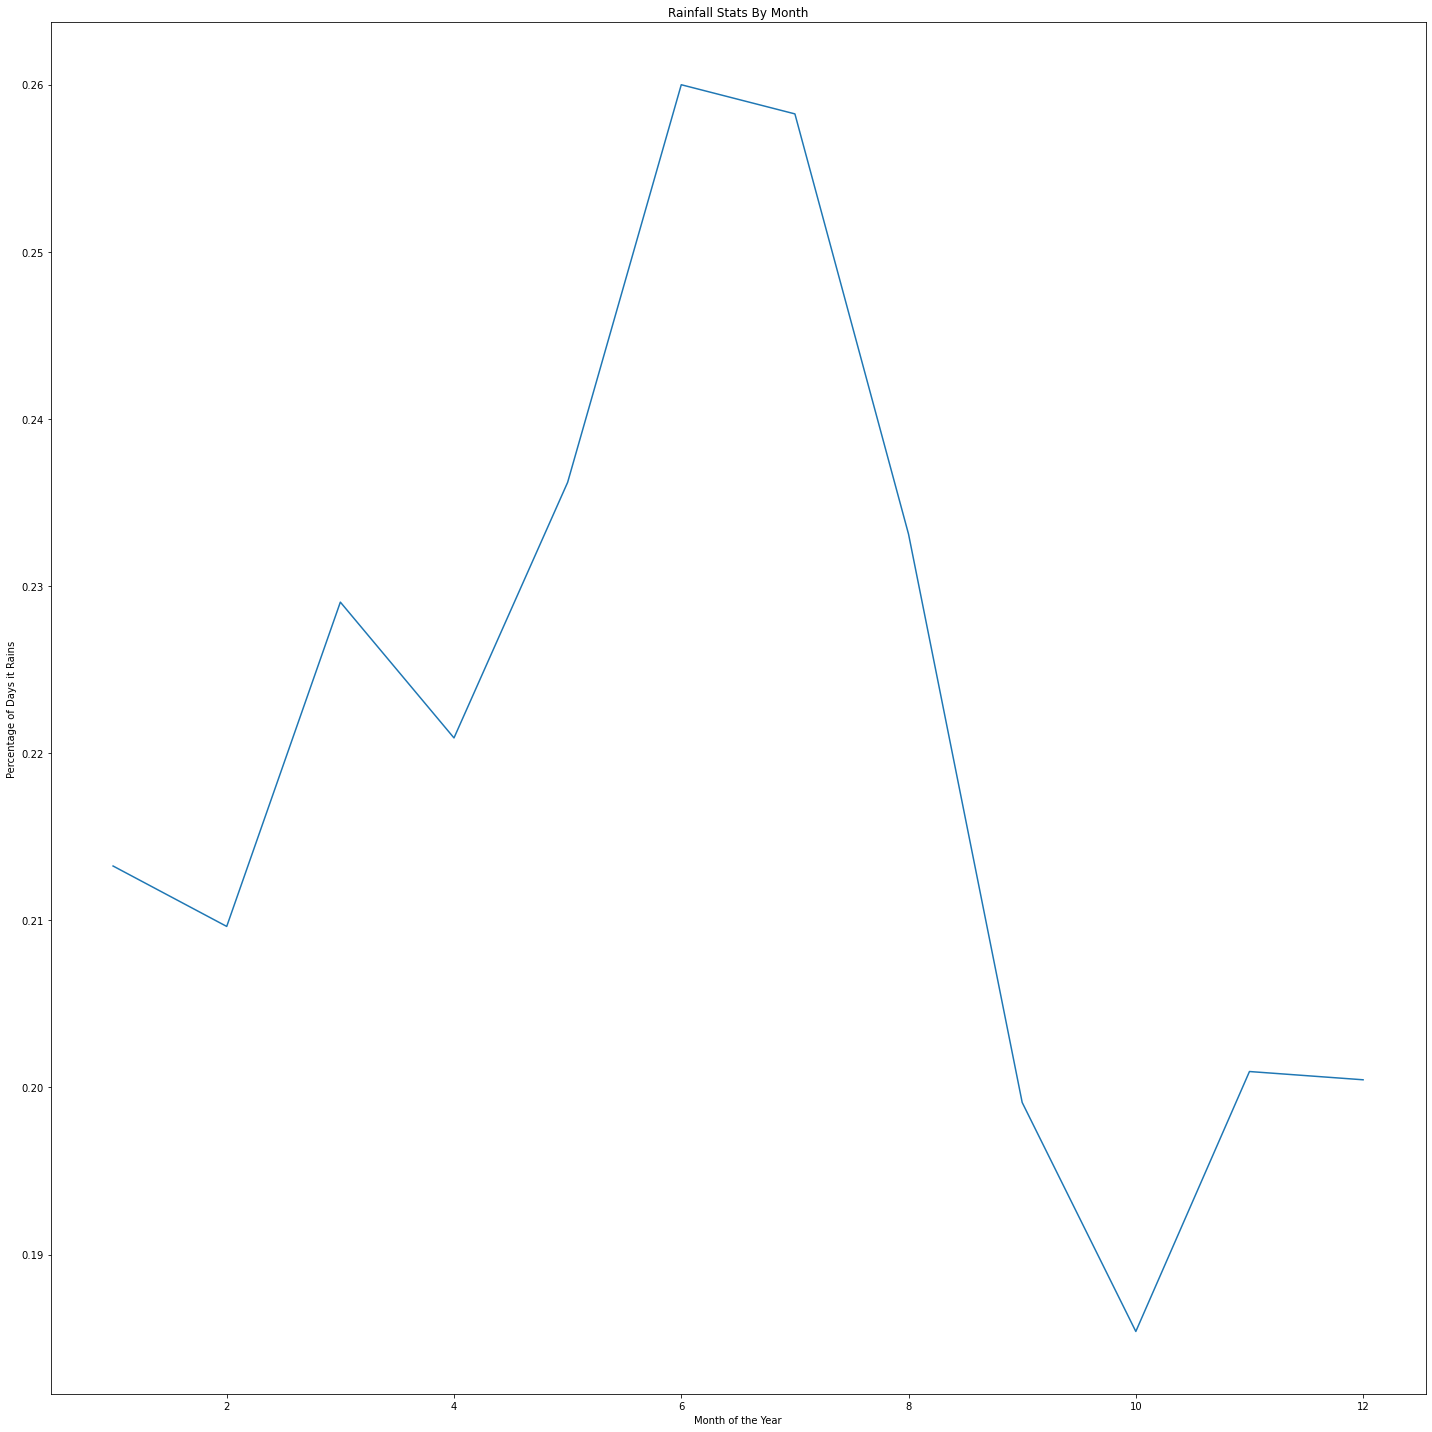

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

df_grouped = df.groupby('month').mean()
df_grouped[['raintoday']]
sns.lineplot(data=df_grouped, x=df_grouped.index, y='raintoday')

plt.title('Rainfall Stats By Month')
plt.xlabel('Month of the Year')
plt.ylabel('Percentage of Days it Rains')
plt.tight_layout();

## Drop Columns Unnecessary for Machine Learning Model
- Date column is not needed for model train as it has been split into Year, Month and Date
- Location will be dropped based on low correlation results from seaborn heatmap and model's feature importance

In [63]:
columns =  ['date', 'location'] 
df = df.drop(columns, axis=1)


In [64]:
print(df.shape)
df.head()

(36929, 24)


,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,17.8,27.1,0.0,6.0,13.0,NE,52.0,NNW,NE,6.0,...,1013.3,2.0,1.0,25.0,26.6,0,0,2011,1,1
1,23.5,30.9,0.0,7.2,11.6,NNE,57.0,NNW,NNE,20.0,...,1009.6,2.0,3.0,27.0,27.4,0,0,2011,1,2
2,22.2,27.6,0.0,3.0,6.3,SSW,46.0,SSW,S,15.0,...,1009.2,7.0,6.0,25.4,26.9,0,0,2011,1,3
3,22.7,27.3,0.0,6.6,6.7,NNE,50.0,SSW,S,30.0,...,1008.3,6.0,7.0,25.2,26.4,0,0,2011,1,4
4,19.2,25.8,0.0,5.0,1.3,SSW,48.0,ESE,ENE,9.0,...,1004.5,7.0,7.0,23.9,25.1,0,1,2011,1,5


## Encode Columns Using OneHotEncoder

In [65]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df_cat

['windgustdir', 'winddir9am', 'winddir3pm']

In [66]:
df[df_cat].nunique()

windgustdir    16
winddir9am     16
winddir3pm     16
dtype: int64

In [67]:
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(df[df_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(df_cat)
encode_df.head()


,windgustdir_E,windgustdir_ENE,windgustdir_ESE,windgustdir_N,windgustdir_NE,windgustdir_NNE,windgustdir_NNW,windgustdir_NW,windgustdir_S,windgustdir_SE,...,winddir3pm_NNW,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SSE,winddir3pm_SSW,winddir3pm_SW,winddir3pm_W,winddir3pm_WNW,winddir3pm_WSW
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(df_cat, axis=1)
df.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,...,winddir3pm_NNW,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SSE,winddir3pm_SSW,winddir3pm_SW,winddir3pm_W,winddir3pm_WNW,winddir3pm_WSW
0,17.8,27.1,0.0,6.0,13.0,52.0,6.0,31.0,58.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.5,30.9,0.0,7.2,11.6,57.0,20.0,41.0,69.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.2,27.6,0.0,3.0,6.3,46.0,15.0,20.0,82.0,77.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.7,27.3,0.0,6.6,6.7,50.0,30.0,31.0,63.0,64.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.2,25.8,0.0,5.0,1.3,48.0,9.0,20.0,65.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
df.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am',
       'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm',
       'temp9am', 'temp3pm', 'raintoday', 'raintomorrow', 'year', 'month',
       'day', 'windgustdir_E', 'windgustdir_ENE', 'windgustdir_ESE',
       'windgustdir_N', 'windgustdir_NE', 'windgustdir_NNE', 'windgustdir_NNW',
       'windgustdir_NW', 'windgustdir_S', 'windgustdir_SE', 'windgustdir_SSE',
       'windgustdir_SSW', 'windgustdir_SW', 'windgustdir_W', 'windgustdir_WNW',
       'windgustdir_WSW', 'winddir9am_E', 'winddir9am_ENE', 'winddir9am_ESE',
       'winddir9am_N', 'winddir9am_NE', 'winddir9am_NNE', 'winddir9am_NNW',
       'winddir9am_NW', 'winddir9am_S', 'winddir9am_SE', 'winddir9am_SSE',
       'winddir9am_SSW', 'winddir9am_SW', 'winddir9am_W', 'winddir9am_WNW',
       'winddir9am_WSW', 'winddir3pm_E', 'winddir3pm_ENE', 'winddir3pm_ESE',
       'winddir3pm_N

## Variable Declaration and Split into Test/Train

In [70]:
# define Target Variable
X = df.copy()
X = X.drop("raintomorrow", axis=1)
y = df["raintomorrow"]

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = 0.8)
print(len(X_train))
print(len(X_test))

29543
7386


## Scale the Data
#### We will use standard scaler for the model

In [71]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Handle Class Imbalance

#### We decided to use Random Oversampling method because of the following reasons:
- SMOTE can be heavily influenced by outliers. 
- Undersampling causes loss of data and even though the dataset reasonably sized, we did not feel comfortable using undersampling
- Random Oversampling produced the highest precision score compared to SMOTE and SMOTEENN

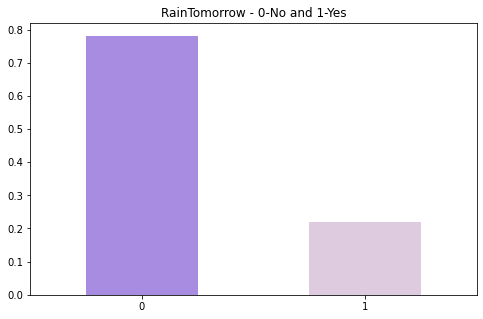

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
df.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['mediumpurple','thistle'], alpha = 0.8, rot=0)
plt.title('RainTomorrow - 0-No and 1-Yes')
plt.show()

In [73]:
# Resample the training data with the RandomOversampler
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)


Counter(y_resampled)

Counter({0: 23061, 1: 23061})

##  Model Comparison:

#### For our model validation, we think precision is more important to predict rainfall (as opposed to sensitivity) in order to accurately plan for droughts. We will use the following for performance evaluation:

- Confusion Matrix
- Classification Report
- Accuracy Score

## 1) Random Forest

In [74]:
# Create a random forest classifier.

from imblearn.ensemble import BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators=128, random_state=42) 

# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

# Making predictions using the testing data.
y_pred_rf = rf_model.predict(X_test_scaled)

# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_rf))

# Calculated the balanced accuracy score
print('Accuracy Score : ', balanced_accuracy_score(y_test, y_pred_rf))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.93      0.61      0.91      0.75      0.59      5765
          1       0.71      0.61      0.93      0.66      0.75      0.55      1621

avg / total       0.85      0.86      0.68      0.86      0.75      0.58      7386

Accuracy Score :  0.7702699767203331
Mean Absolute Error: 0.13918223666395885
Mean Squared Error: 0.13918223666395885
Root Mean Squared Error: 0.3730713559950145


In [75]:
# Calculating the confusion matrix.
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create a DataFrame from the confusion matrix.
cm_df_rf = pd.DataFrame(cm_rf, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df_rf

,Predicted 0,Predicted 1
Actual 0,5371,394
Actual 1,634,987


#### Feature Importance

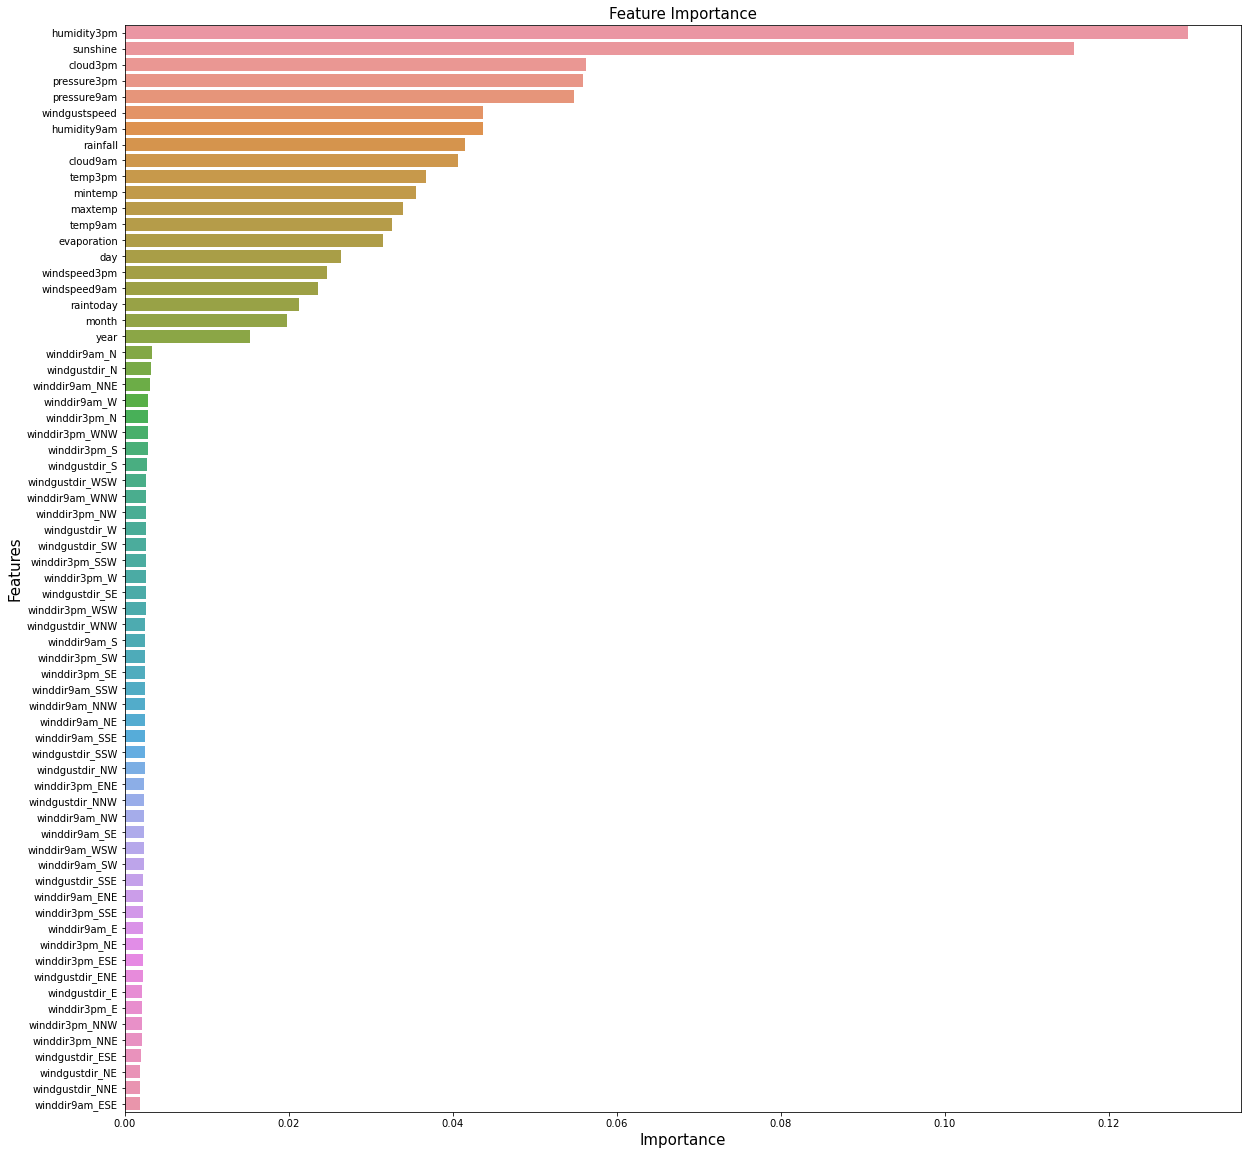

In [76]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_

#for importance, feat in sorted(zip(rf_model.feature_importances_, X.columns), reverse=True):
#    print(f'{feat}: ({importance})')

import matplotlib.pyplot as plt

important_features = pd.DataFrame({'Features': X.columns, 
                                   'Importance': rf_model.feature_importances_})

# print the dataframe
important_features.sort_values(by='Importance', ascending=False, inplace=True)

plt.rcParams['figure.figsize'] = 20,20
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

## 2) Gradient Boosting

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

gb_model.fit(X_resampled, y_resampled)

y_pred_gb=gb_model.predict(X_test_scaled)

print(classification_report_imbalanced(y_test, y_pred_gb))
print('Accuracy Score : ',balanced_accuracy_score(y_test, y_pred_gb))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_gb))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_gb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.81      0.80      0.87      0.80      0.64      5765
          1       0.54      0.80      0.81      0.64      0.80      0.64      1621

avg / total       0.85      0.80      0.80      0.82      0.80      0.64      7386

Accuracy Score :  0.8011115492508613
Mean Absolute Error: 0.1959111833197942
Mean Squared Error: 0.1959111833197942
Root Mean Squared Error: 0.44261855284182816


In [78]:
# Calculating the confusion matrix.
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Create a DataFrame from the confusion matrix.
cm_df_gb = pd.DataFrame(cm_gb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
 
cm_df_gb

,Predicted 0,Predicted 1
Actual 0,4649,1116
Actual 1,331,1290


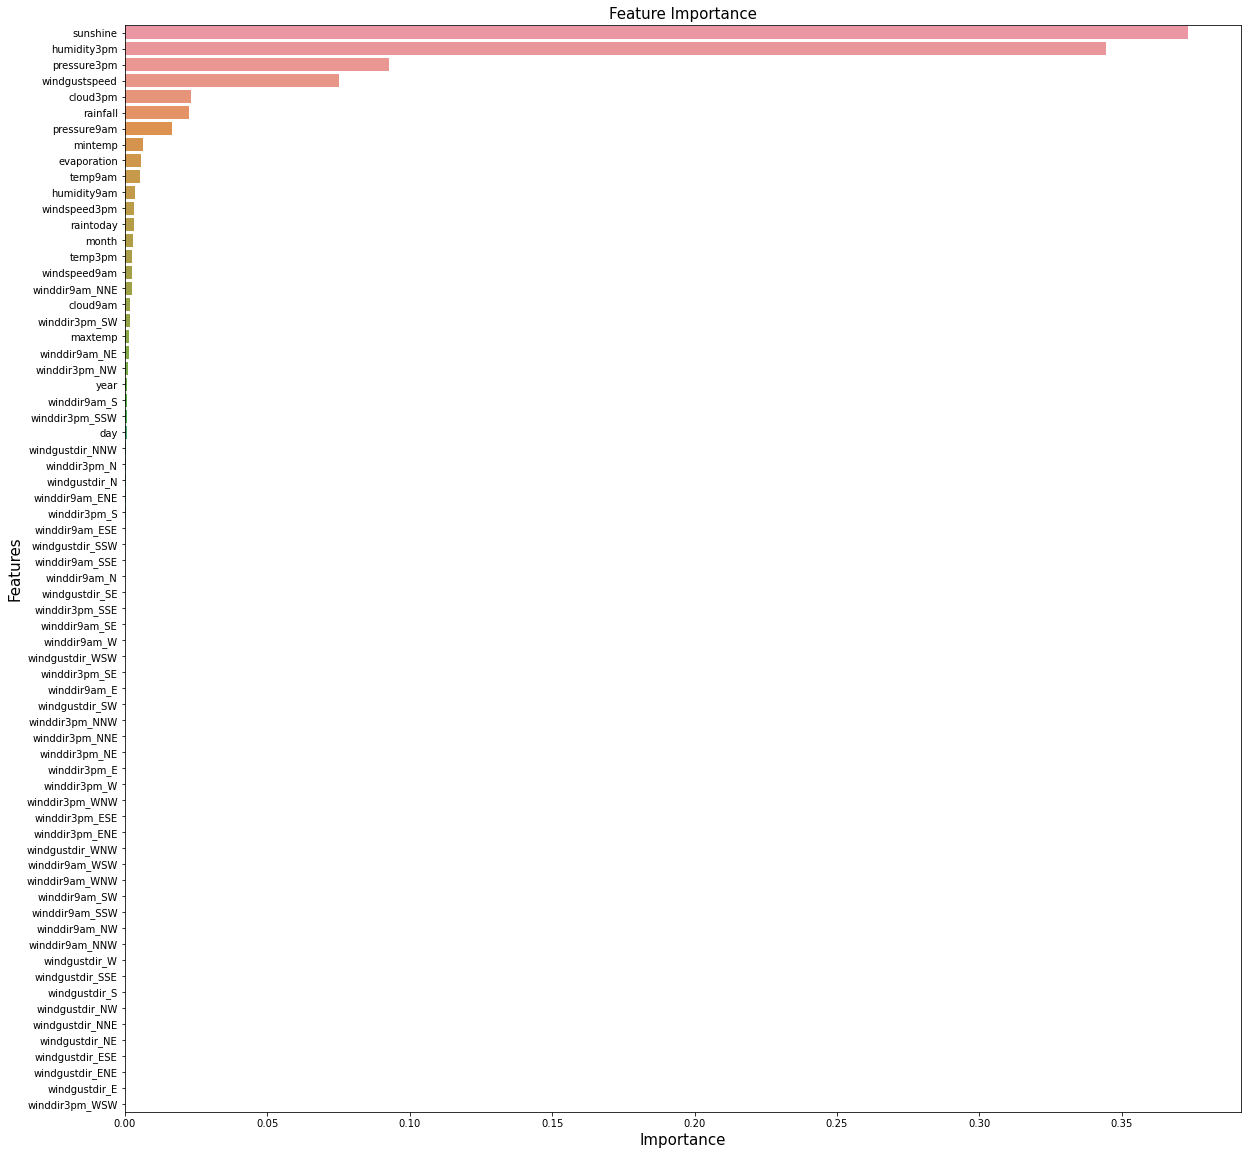

In [79]:
# List the features sorted in descending order by feature importance
import matplotlib.pyplot as plt

important_features_gb = pd.DataFrame({'Features': X.columns, 
                                   'Importance': gb_model.feature_importances_})

# print the dataframe
important_features_gb.sort_values(by='Importance', ascending=False, inplace=True)

plt.rcParams['figure.figsize'] = 20,20
sns.barplot(x = 'Importance', y = 'Features', data = important_features_gb)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

## 3) Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_resampled,y_resampled)

y_pred_lr = lr_model.predict(X_test_scaled)

print(classification_report_imbalanced(y_test, y_pred_lr))
print('Accuracy Score : ',balanced_accuracy_score(y_test, y_pred_lr))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.81      0.79      0.87      0.80      0.64      5765
          1       0.54      0.79      0.81      0.64      0.80      0.64      1621

avg / total       0.85      0.81      0.79      0.82      0.80      0.64      7386

Accuracy Score :  0.8017081743144644
Mean Absolute Error: 0.19117248849174112
Mean Squared Error: 0.19117248849174112
Root Mean Squared Error: 0.4372327623723331


In [81]:
# Calculating the confusion matrix.
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Create a DataFrame from the confusion matrix.
cm_df_lr = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
 
cm_df_lr

,Predicted 0,Predicted 1
Actual 0,4695,1070
Actual 1,342,1279


In [82]:
# List the features sorted in descending order by feature importance


## Model Comparison

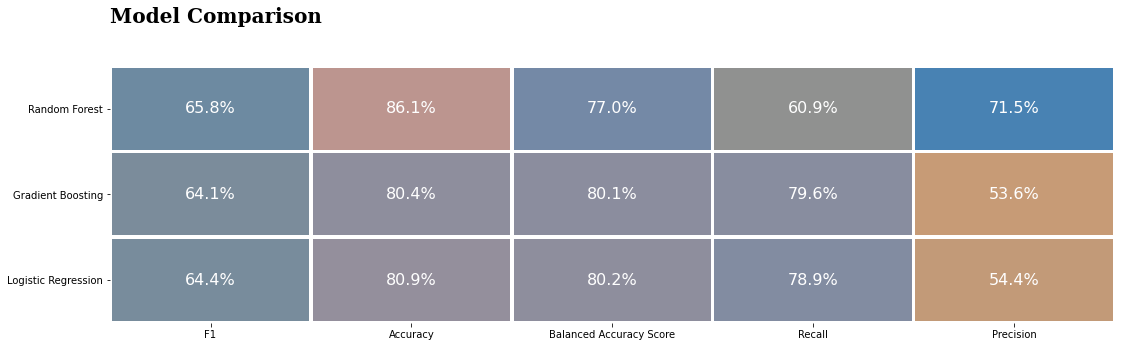

In [86]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib

rf_df = pd.DataFrame(data=[f1_score(y_test,y_pred_rf)
                            , accuracy_score(y_test, y_pred_rf)                            
                            , balanced_accuracy_score(y_test, y_pred_rf)
                            , recall_score(y_test, y_pred_rf)
                            , precision_score(y_test, y_pred_rf)],
                            #, roc_auc_score(y_test, y_pred_rf)], 
                      columns=['Random Forest'], 
                      index=["F1","Accuracy", "Balanced Accuracy Score", "Recall", "Precision"])


gb_df = pd.DataFrame(data=[f1_score(y_test,y_pred_gb)
                            , accuracy_score(y_test, y_pred_gb)
                            , balanced_accuracy_score(y_test, y_pred_gb)
                            , recall_score(y_test, y_pred_gb)
                            , precision_score(y_test, y_pred_gb)],                          
                      columns=['Gradient Boosting'], 
                      index=["F1","Accuracy", "Balanced Accuracy Score", "Recall", "Precision"])

lr_df = pd.DataFrame(data=[f1_score(y_test,y_pred_lr)
                            , accuracy_score(y_test, y_pred_lr)
                            , balanced_accuracy_score(y_test, y_pred_lr)
                            , recall_score(y_test, y_pred_lr)
                            , precision_score(y_test, y_pred_lr)],                             
                      columns=['Logistic Regression'], 
                      index=["F1","Accuracy", "Balanced Accuracy Score", "Recall", "Precision"])


df_models = round(pd.concat([rf_df, gb_df, lr_df], axis=1),3)
colors =  ["bisque","ivory","sandybrown","steelblue","lightsalmon"]
# ["bisque","ivory","sandybrown","steelblue","lightsalmon"]                           
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "white"

fig = plt.figure(figsize=(18,26)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":16})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-0.5,'Model Comparison',fontsize=20,fontweight='bold',fontfamily='serif')
plt.show()